In [ ]:
# Imports
import os
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
from operator import itemgetter
import math

In [ ]:
# Setting Directory to the LCR Data Set.
# Then, sets up a Data Frame of the unfiltered data.
# Finally, prints out the unfiltered data as a table.
os.getcwd()
os.chdir('/Users/glatiolait/Documents/LCR/LCR_files+scripts')
table = "new_db_Feb2023.csv"
opened = open(table,"r")
readed = pd.read_csv(table, sep=",")
tablelist = list(csv.reader(readed))
data_array = np.array(readed)
df = pd.DataFrame(data_array)

In [ ]:
# Prompts the User for a selection of Cadence values. 
# I accounted for possible misspellings regarding capitalization.
# If the cadence value inputted is incorrect, then an error is displayed.
# The function then takes the inputted cadence string, and filters the DataFrame table with that.

cadence = input("Input Cadence Selection. (daily, weekly, or monthly) Case Sensitive.")
if cadence not in ['daily', 'Daily', 'weekly', 'Weekly', 'monthly', 'Monthly']:
    print("Error. Invalid option")

# This section takes the user input for cadence, and then outputs a data set for a random source within that cadence value.
# The randomsource variable takes a random name from the list, so some sources may be weighted far more heavily than others.
# I am not sure if the randomness is necessary, but it allowed an easy way to test multiple graphs.
# I have also included a default source name to check against consistently.

randomsource = np.random.choice(data_array[:,1])
randomsource = '4FGL J0001.2-0747'


# Prints out which source was randomly picked. Not necessary for using the default option.
print(randomsource)

# Filters the catalogue to only randomsource, cadence, sigma values larger than 4, and photon flux values greater than their error margins.
sortedsource = np.where((data_array[:,1] == randomsource) & (data_array[:,2]==cadence) & (data_array[:,-1] >= 4) & (data_array[:,6] < data_array[:,5]))

# Displays the dataframe to ensure everything is working as intended. Will omit in the future.
pd.DataFrame(data_array[sortedsource])

In [ ]:
def ransource():
    # This function takes the user input for cadence, and then outputs a data set for a random source within that cadence value.
    # I am not sure if the randomness is necessary, but it allowed an easy way to test multiple graphs.
    
    names = df.drop_duplicates(subset=[1], inplace=False)[1]
    randomsource = np.random.choice(names)

    print(randomsource)

    # Filters the catalogue to only randomsource, cadence, sigma values larger than 4, and photon flux values greater than their error margins.
    sortedsource = np.where((data_array[:,1] == randomsource) & (data_array[:,2]==cadence) & (data_array[:,-1] >= 4) & (data_array[:,6] < data_array[:,5]))

    # Displays the dataframe to ensure everything is working as intended. Will omit in the future.
    #pd.DataFrame(data_array[sortedsource])

    # This block of code is where a majority of the plots will go.

    GraphTest = (data_array[sortedsource])
    Plot = pd.DataFrame(GraphTest)
    ysize = GraphTest.size
    x = pd.DataFrame(GraphTest[:,3]/(60*60*24*365))

    # The title displays the name of the graph, with references that will vary the cadence and name of the source.
    plt.title("Photon Flux vs " + GraphTest[0,2] + " Cadence of " + GraphTest[0,1])

    # The x-axis displays the time elapsed in seconds. I would like to convert this to be a range of years.
    plt.xlabel("Mission Elapsed Time (seconds)")

    # The y-axis displays the Photon Flux. I don't believe the numerical labels are correct, but the shape of the graph appears to be correct.
    plt.ylabel("Photon Flux (GeV ph cm^-2 s^-1)")

    # This is the actual function that plots the data. At the moment, it plots column 3 (Time) vs column 5 (Photon Flux)
    #Graph = plt.plot(Plot[3],Plot[5])
    plt.errorbar(Plot[3],Plot[5],yerr=Plot[6],fmt = 'o-')
    plt.hlines(np.mean(GraphTest[:,5]),2e8,7e8)


In [ ]:
# This loop processes the entire database
# It goes through each source, and determines the average flux of the entire source, and the fraction of the flux at each of those time bins.

names = df.drop_duplicates(subset=[1], inplace=False)[1]
fmatrix = []
fractionalflux = []
for name in names:
    print(name)
    source_array = (data_array[np.where(data_array[:,1] == name)])
    averageflux = np.nanmean(source_array[:,5])
    flux = source_array[:,5]
    flux_err = source_array[:,6]

    factors = source_array[:,5]/averageflux

    fmatrix.append(factors)
    print(factors)
    fractionalflux.append((name,factors,averageflux,flux,flux_err))


pd.DataFrame(fractionalflux)

In [ ]:
# This is just for making the files look nicer. I dont believe that this will affect the actual arrays.
fractionalflux=pd.DataFrame(fractionalflux).rename(columns={0: 'source_name', 1: 'flux_values',2: 'average_flux'})


([<matplotlib.axis.YTick at 0x5a4bd6b90>,
  ...],
 [Text(0, 0.0, '0'),
  Text(0, 1.0, '1'),
  Text(0, 2.0, '2'),
  Text(0, 3.0, '3'),
  Text(0, 4.0, '4'),
  Text(0, 5.0, '5'),
  Text(0, 6.0, '6'),
  Text(0, 7.0, '7'),
  Text(0, 8.0, '8'),
  Text(0, 9.0, '9'),
  Text(0, 10.0, '10'),
  Text(0, 11.0, '11'),
  Text(0, 12.0, '12'),
  Text(0, 13.0, '13'),
  Text(0, 14.0, '14'),
  Text(0, 15.0, '15'),
  Text(0, 16.0, '16'),
  Text(0, 17.0, '17'),
  Text(0, 18.0, '18'),
  Text(0, 19.0, '19'),
  Text(0, 20.0, '20'),
  Text(0, 21.0, '21'),
  Text(0, 22.0, '22'),
  Text(0, 23.0, '23'),
  Text(0, 24.0, '24'),
  Text(0, 25.0, '25'),
  Text(0, 26.0, '26'),
  Text(0, 27.0, '27'),
  Text(0, 28.0, '28'),
  Text(0, 29.0, '29'),
  Text(0, 30.0, '30'),
  Text(0, 31.0, '31'),
  Text(0, 32.0, '32'),
  Text(0, 33.0, '33'),
  Text(0, 34.0, '34'),
  Text(0, 35.0, '35'),
  Text(0, 36.0, '36'),
  Text(0, 37.0, '37'),
  Text(0, 38.0, '38'),
  Text(0, 39.0, '39'),
  Text(0, 40.0, '40'),
  Text(0, 41.0, '41'),
  Te

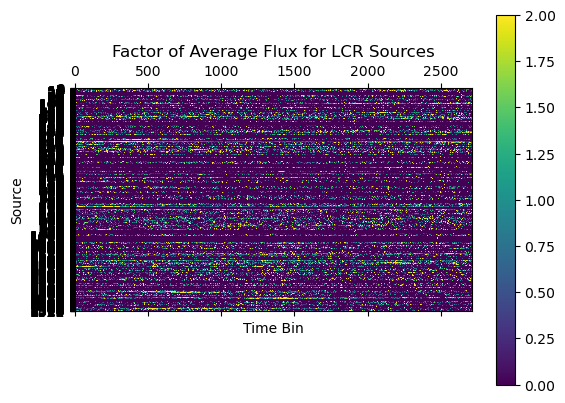

In [136]:
# This section plots each fractional point as a color-coded plot. 
# Currently Playing with different methods of adding labels to the left side of the plot.
fmatrix=np.array(fmatrix)
fmatrix = np.nan_to_num(fmatrix.astype(np.float64), nan=0.0)
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(fmatrix,interpolation='nearest')
fig.colorbar(cax)
cax.set_clim(0,2)
ax.set_title("Factor of Average Flux for LCR Sources")
ax.set_xlabel("Time Bin")
ax.set_ylabel("Source")
alpha = pd.DataFrame(fractionalflux)[0].tolist()
plt.yticks(np.arange(0,len(alpha),1.0))
#ax.imshow(fmatrix, extent = [0,3000,0,10000], aspect ='auto')
#ax.get_yticks()
#ax.set_yticklabels(['']+alpha)


In [ ]:
def fvar(flux,flux_err):
	#Based on Equation (34) from K. K. Singh & P. J. Meintjes, Astronomische Nachrichten, Volume 341, Issue 713, pp. 713-725
	#Error calculated with Equation (37) of the same paper

	N=len(flux)
	variance=np.nanvar(flux) #variance
	mean_squared_error=(1/N)*np.nansum(flux_err**2)
	mean_flux=np.nanmean(flux)

	num=variance-mean_squared_error
	den=mean_flux**2

	fvar=np.sqrt(num/den)

	fvar_err=np.sqrt(fvar**2 + np.sqrt((2/N) * (mean_squared_error/den)**2 + (mean_squared_error/N) * (2*fvar/mean_flux)**2 )) - fvar

	return fvar,fvar_err


def fvar_percent(flux,flux_err):
	#Based on Equation (34) from K. K. Singh & P. J. Meintjes, Astronomische Nachrichten, Volume 341, Issue 713, pp. 713-725
	#Error calculated with Equation (37) of the same paper
	#Fvar value (and error) multiplied by 100 to express the fractional variability as a "percentage-scaled" value

	N=len(flux)
	variance=np.nanvar(flux) #variance
	mean_squared_error=(1/N)*np.nansum(flux_err**2)
	mean_flux=np.nanmean(flux)

	num=variance-mean_squared_error
	den=mean_flux**2

	fvar=np.sqrt(num/den)

	fvar_err=np.sqrt(fvar**2 + np.sqrt((2/N) * (mean_squared_error/den)**2 + (mean_squared_error/N) * (2*fvar/mean_flux)**2 )) - fvar

	return fvar*100,fvar_err*100

In [ ]:
# This tests the flux variability functions with a source. The function automatically overlooks NaN values.
flux = fractionalflux[1][3]
flux_err = fractionalflux[1][4]
print(fvar(flux,flux_err))
print(fvar_percent(flux,flux_err))